In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = 10, 20
from sklearn.decomposition import PCA
from scipy import misc
import imageio
import numpy as np
import glob
from sklearn.preprocessing import normalize

Populating the interactive namespace from numpy and matplotlib


In [2]:
def toYCrCb(image):
    YRCoeff = 0.257
    YGCoeff = 0.504
    YBCoeff = 0.098
    YConstant = 16
    
    CrRCoeff = 0.439
    CrGCoeff = 0.368
    CrBCoeff = 0.071
    CrConstant = 128
    
    CbRCoeff = 0.148
    CbGCoeff = 0.291
    CbBCoeff = 0.439
    CbConstant = 128
    
    reds = image[:, :, 0]
    greens = image[:, :, 1]
    blues = image[:, :, 2]
    
    Y  = YRCoeff * reds + YGCoeff * greens + YBCoeff * blues + YConstant
    Cr = CrRCoeff * reds - CrGCoeff * greens - CrBCoeff * blues + CrConstant
    Cb = -(CbRCoeff * reds) - CbGCoeff * greens + CbBCoeff * blues + CbConstant
    
    result = np.empty(shape=(image.shape[0], image.shape[1], 3))
    result[:, :, 0] = Y
    result[:, :, 1] = Cr
    result[:, :, 2] = Cb
    
    return result
    
def toRGB(image):
    YCoeff = 1.164
    
    BCbCoeff = 2.018
    
    GCrCoeff = -0.813
    GCbCoeff = -0.391
    
    RCrCoeff = 1.596
    
    Y = image[:, :, 0]
    Cr = image[:, :, 1]
    Cb = image[:, :, 2]
    
    Y -= 16
    Cr -= 128
    Cb -= 128
    
    YPiece = Y * YCoeff
    blues = YPiece + BCbCoeff * Cb
    greens = YPiece + (GCrCoeff * Cr) + (GCbCoeff * Cb)
    reds = YPiece + (RCrCoeff * Cr)
    
    result = np.empty(shape=(image.shape[0], image.shape[1], 3))
    
    overflowedReds = reds > 255
    overflowedGreens = greens > 255
    overflowedBlues = blues > 255
    
    underflowedReds = reds < 0
    underflowedGreens = greens < 0
    underflowedBlues = blues < 0
    
    reds[overflowedReds] = 255.
    greens[overflowedGreens] = 255.
    blues[overflowedBlues] = 255.
    
    reds[underflowedReds] = 0.
    greens[underflowedGreens] = 0.
    blues[underflowedBlues] = 0.
    
    result[:, :, 0] = reds
    result[:, :, 1] = greens
    result[:, :, 2] = blues
    
    return result

In [3]:
testSet = glob.glob('./faces/testset/*.jpg')
trainSet = glob.glob('./faces/trainset/*.jpg')

TestSetMatrix = np.empty(shape=(len(testSet), 32 * 32))
TrainSetMatrix = np.empty(shape=(len(trainSet), 32 * 32))

testImageInd = 0
for testImagePath in testSet:
    image = misc.imresize(imageio.imread(testImagePath).astype(np.float), (32, 32))
    TestSetMatrix[testImageInd] = image.ravel()
    testImageInd += 1
    
trainImageInd = 0
for trainImagePath in trainSet:
    image = misc.imresize(imageio.imread(trainImagePath).astype(np.float), (32, 32))
    image = toYCrCb(image)
    
    TrainSetMatrix[trainImageInd] = image[:, :, 0].ravel()
    trainImageInd += 1
    

In [4]:
def DistanceMatrix(TestSet, TrainSet):
  SM1 = np.sum(TestSet ** 2, axis=1)
  SM2 = np.sum(TrainSet ** 2, axis=1)

  M1M2_2 = -2 * np.dot(TestSet, TrainSet.T)

  return M1M2_2 + SM1.reshape(SM1.shape[0], 1) + SM2

In [5]:
DM = DistanceMatrix(TestSetMatrix, TrainSetMatrix)
Similar = np.argsort(DM)[:, :1]
%timeit DistanceMatrix(TestSetMatrix, TrainSetMatrix)
%timeit np.argsort(DM)[:, :1]

1 loop, best of 3: 310 ms per loop
1 loop, best of 3: 256 ms per loop


/Users/Killavus/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  app.launch_new_instance()


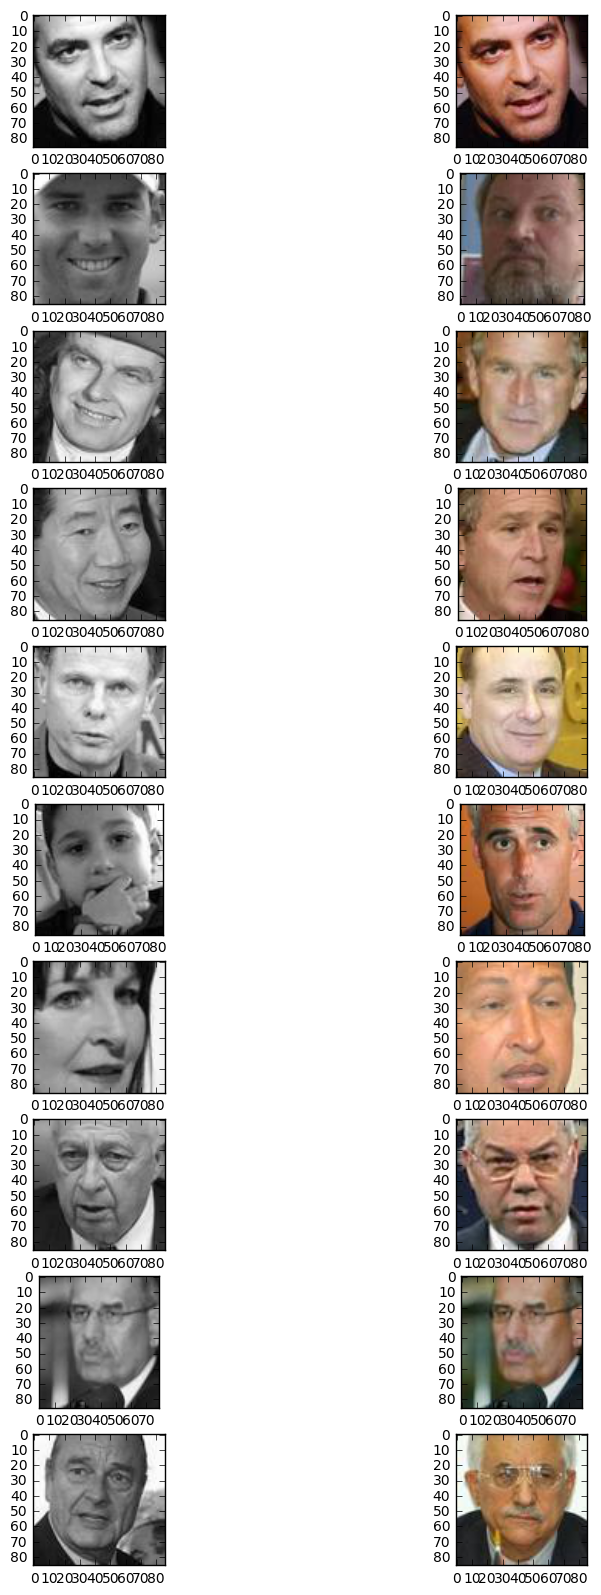

In [6]:
for index in range(10):
    testImage = imageio.imread(testSet[index])
    similarImage = imageio.imread(trainSet[Similar[index]])
    
    subplot(10, 2, index * 2 + 1)
    imshow(testImage, cmap='gray')
    subplot(10, 2, index * 2 + 2)
    imshow(similarImage)

/Users/Killavus/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


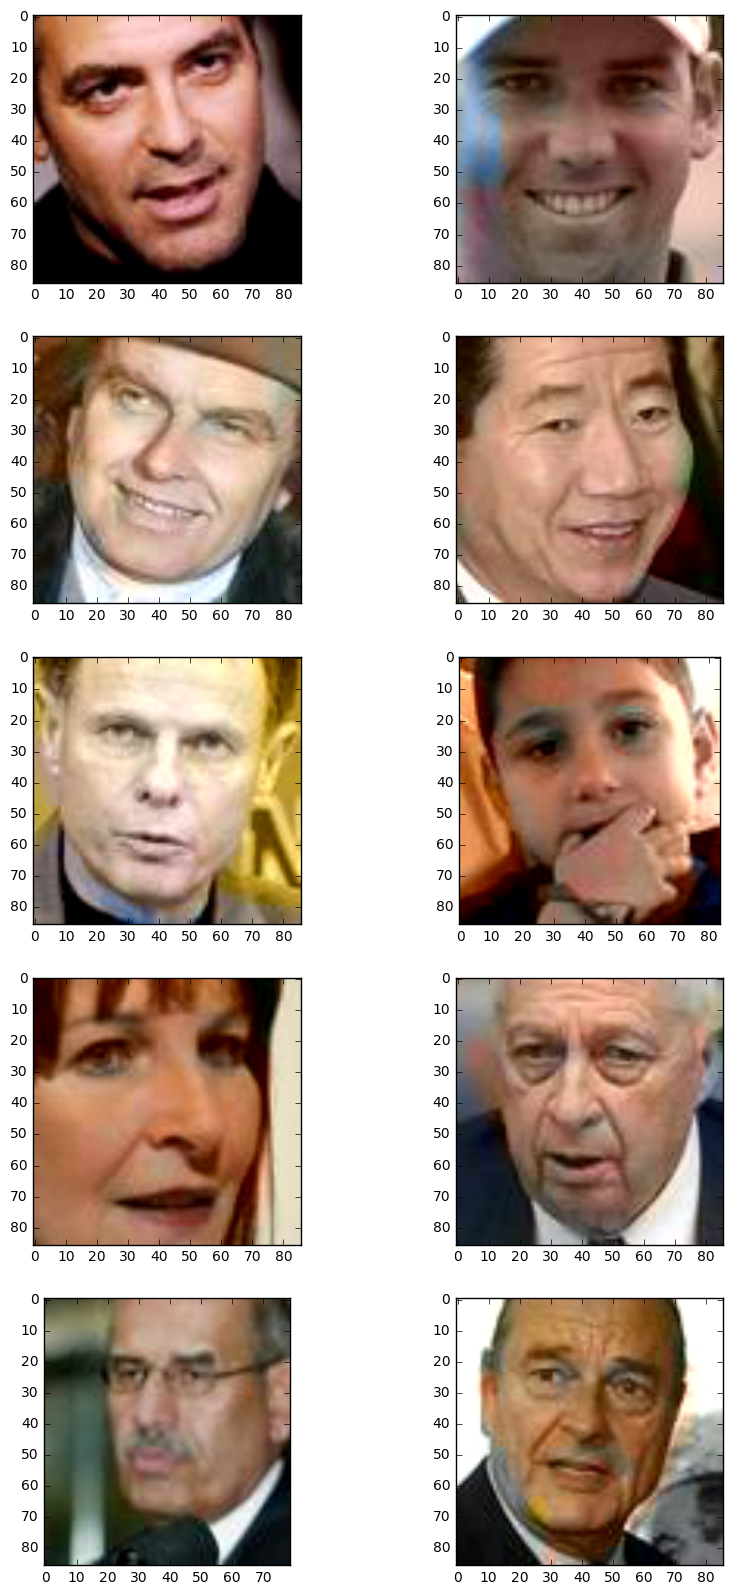

In [7]:
index = 0
for imagePath in testSet:
    testImage = imageio.imread(imagePath).astype(np.float)
    result = np.empty(shape=(testImage.shape[0], testImage.shape[1], 3))
    
    similarImage = imageio.imread(trainSet[Similar[index]]).astype(np.float)
    if similarImage.shape[:2] != testImage.shape[:2]:
        similarImage = misc.imresize(similarImage, testImage.shape[:2])
        
    similarImage = toYCrCb(similarImage)
    result[:, :, 0] = testImage
    result[:, :, 1] = similarImage[:, :, 1]
    result[:, :, 2] = similarImage[:, :, 2]
    result = toRGB(result)
    
    if index < 10:
        subplot(5, 2, index + 1)
        imshow(result / 255.0)
    
    imageio.imwrite(imagePath.replace('testset', 'testset_colorized'), result)
    index += 1

In [20]:
PCAInstance = PCA(n_components=19)
CompressedTrainSet = PCAInstance.fit_transform(TrainSetMatrix)
CompressedTestSet = np.empty(shape=(TestSetMatrix.shape[0], 19))
for i in range(TestSetMatrix.shape[0]):
    CompressedTestSet[i] = PCAInstance.transform([TestSetMatrix[i]])

10 loops, best of 3: 44.8 ms per loop
1 loop, best of 3: 263 ms per loop


/Users/Killavus/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


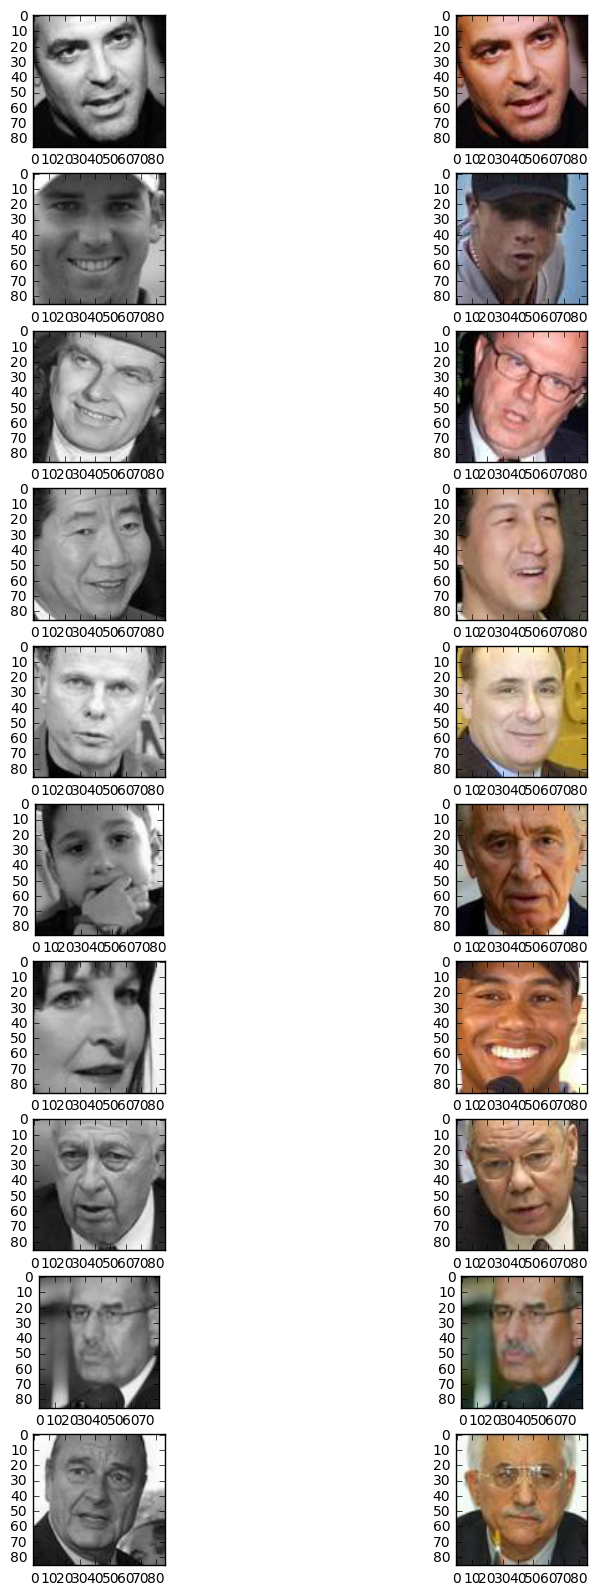

In [21]:
PCADM = DistanceMatrix(CompressedTestSet, CompressedTrainSet)
PCASimilar = np.argsort(PCADM)[:, :1]
%timeit DistanceMatrix(CompressedTestSet, CompressedTrainSet)
%timeit np.argsort(PCADM)[:, :1]

for index in range(10):
    testImage = imageio.imread(testSet[index])
    similarImage = imageio.imread(trainSet[PCASimilar[index]])
    
    subplot(10, 2, index * 2 + 1)
    imshow(testImage, cmap='gray')
    subplot(10, 2, index * 2 + 2)
    imshow(similarImage)

/Users/Killavus/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


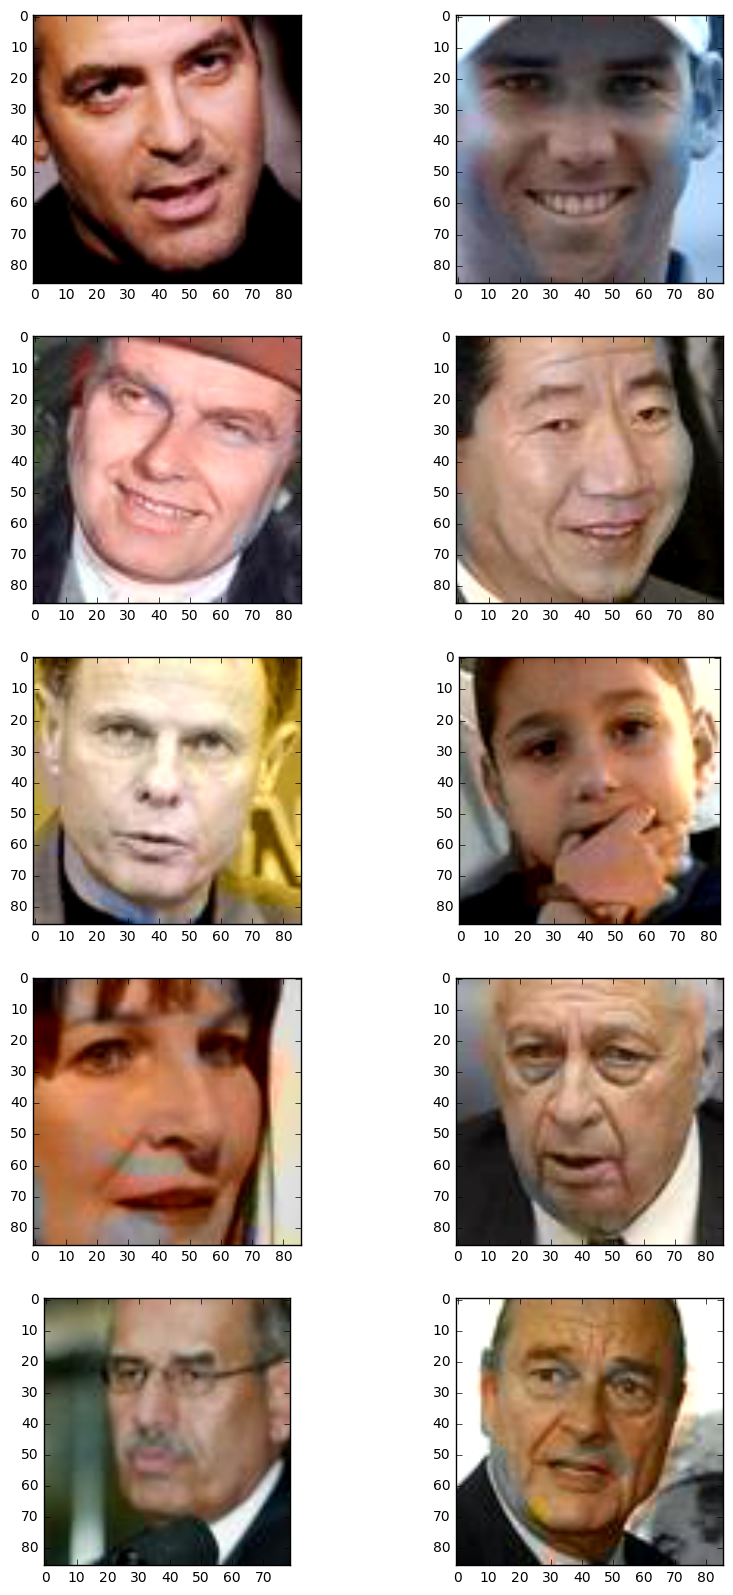

In [22]:
index = 0
for imagePath in testSet:
    testImage = imageio.imread(imagePath).astype(np.float)
    result = np.empty(shape=(testImage.shape[0], testImage.shape[1], 3))
    
    similarImage = imageio.imread(trainSet[PCASimilar[index]]).astype(np.float)
    if similarImage.shape[:2] != testImage.shape[:2]:
        similarImage = misc.imresize(similarImage, testImage.shape[:2])
        
    similarImage = toYCrCb(similarImage)
    result[:, :, 0] = testImage
    result[:, :, 1] = similarImage[:, :, 1]
    result[:, :, 2] = similarImage[:, :, 2]
    result = toRGB(result)
    
    if index < 10:
        subplot(5, 2, index + 1)
        imshow(result / 255.0)
    
    imageio.imwrite(imagePath.replace('testset', 'testset_colorized_pca'), result)
    index += 1